
# Global fit to all three K2 campaign lightcurves

and ASASSN! and ALL campaigns!

In [1]:
# %load /Users/obsidian/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# subsub K2

In [2]:
! ls ../data/K2/

S1063_K2_C05_lightkurve_SFF.csv S1063_K2_C18_lightkurve_SFF.csv
S1063_K2_C16_lightkurve_SFF.csv


In [3]:
dfC05 = pd.read_csv('../data/K2/S1063_K2_C05_lightkurve_SFF.csv')
dfC16 = pd.read_csv('../data/K2/S1063_K2_C16_lightkurve_SFF.csv')
dfC18 = pd.read_csv('../data/K2/S1063_K2_C18_lightkurve_SFF.csv')

### Read in the ASASSN data.

In [4]:
usecols = ['HJD', 'flux(mJy)', 'flux_err', 'Filter']
df_ASASSN = pd.read_csv('../data/raw/ASASSN/S1063_ASASSN_20190123.csv', usecols=usecols)

# Tidy up the dataframe
df_ASASSN = df_ASASSN[df_ASASSN.flux_err!=99.990].reset_index(drop=True)
df_ASASSN.rename(columns={'flux(mJy)':'flux', 'HJD':'time'},inplace=True)
df_ASASSN['time'] = df_ASASSN['time'] - 2454833.0

# Focus on one filter at a time...
filt = 'V'
df_ASASSN = df_ASASSN[df_ASASSN.Filter == filt].reset_index(drop=True)[['time', 'flux', 'flux_err']]
const = np.percentile(df_ASASSN.flux, 80)

# Normalize
df_ASASSN['flux'] /=const
df_ASASSN['flux_err'] /=const

# drop outliers
good_mask = (df_ASASSN.flux > 0.7) & (df_ASASSN.time < 3500)
df_ASASSN = df_ASASSN[good_mask].reset_index(drop=True)

Read in the AAVSO data.

In [5]:
keep_cols = ['JD', 'Magnitude', 'Uncertainty', 'Band']
df = pd.read_csv('../data/raw/aavsodata_5c5df877134a9.txt', usecols=keep_cols)

v_band = df.Band == 'V'

df['mag']= df.Magnitude.str.lstrip('<').astype(np.float)
df['JD_like']= df.JD.astype(np.float)

df = df[v_band]
df = df.reset_index(drop=True)[['JD_like', 'mag', 'Uncertainty', 'Band']]

In [6]:
df_AAVSO = df

In [15]:
df_AAVSO['flux'] = 10**(df_AAVSO.mag/-2.5)
const = np.nanmedian(df_AAVSO['flux'])
df_AAVSO['flux'] = df_AAVSO['flux'] / const
df_AAVSO['time'] = df_AAVSO.JD_like - 2454833.0

In [13]:
# Here we retroactively assign the campaign zeropoints, which are not known a-priori.
C05_const, C16_const, C18_const = 76956.4, 73136.2, 77089.98 # iteratively computed at bottom.
dfC05['flux'] = dfC05['flux'] / C05_const
dfC16['flux'] = dfC16['flux'] / C16_const
dfC18['flux'] = dfC18['flux'] / C18_const

df = pd.concat([dfC05, dfC16, dfC18], ignore_index=True)

# df['flux'] = df.flux / np.percentile(df.flux, 98) Turn of if you normalize campaigns separately!
df['flux_err'] = df.flux *0.005

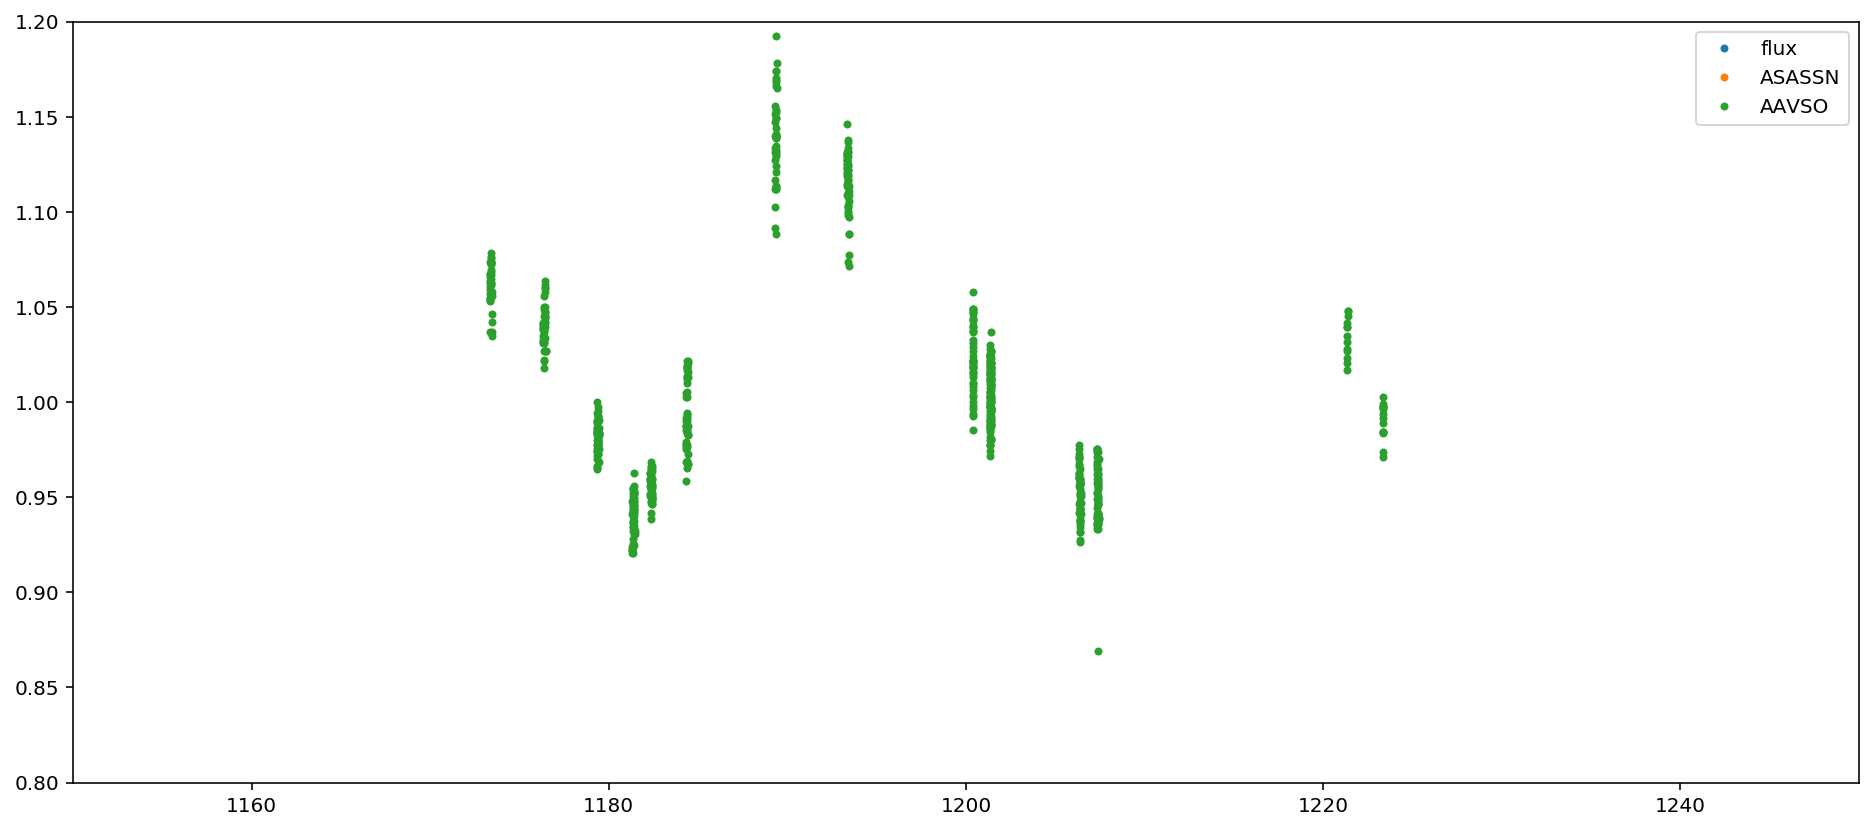

In [22]:
plt.figure(figsize=(16, 7))
plt.plot(df.time, df.flux, '.')
#plt.plot(dfC05.time, dfC05.flux/ np.percentile(dfC05.flux, 98), 'r.')
plt.plot(df_ASASSN.time, df_ASASSN.flux, '.', label='ASASSN')
plt.plot(df_AAVSO.time, df_AAVSO.flux, '.', label='AAVSO')
plt.xlim(1150, 1250)
plt.ylim(0.8, 1.2)
plt.legend()

(0.8, 1.2)

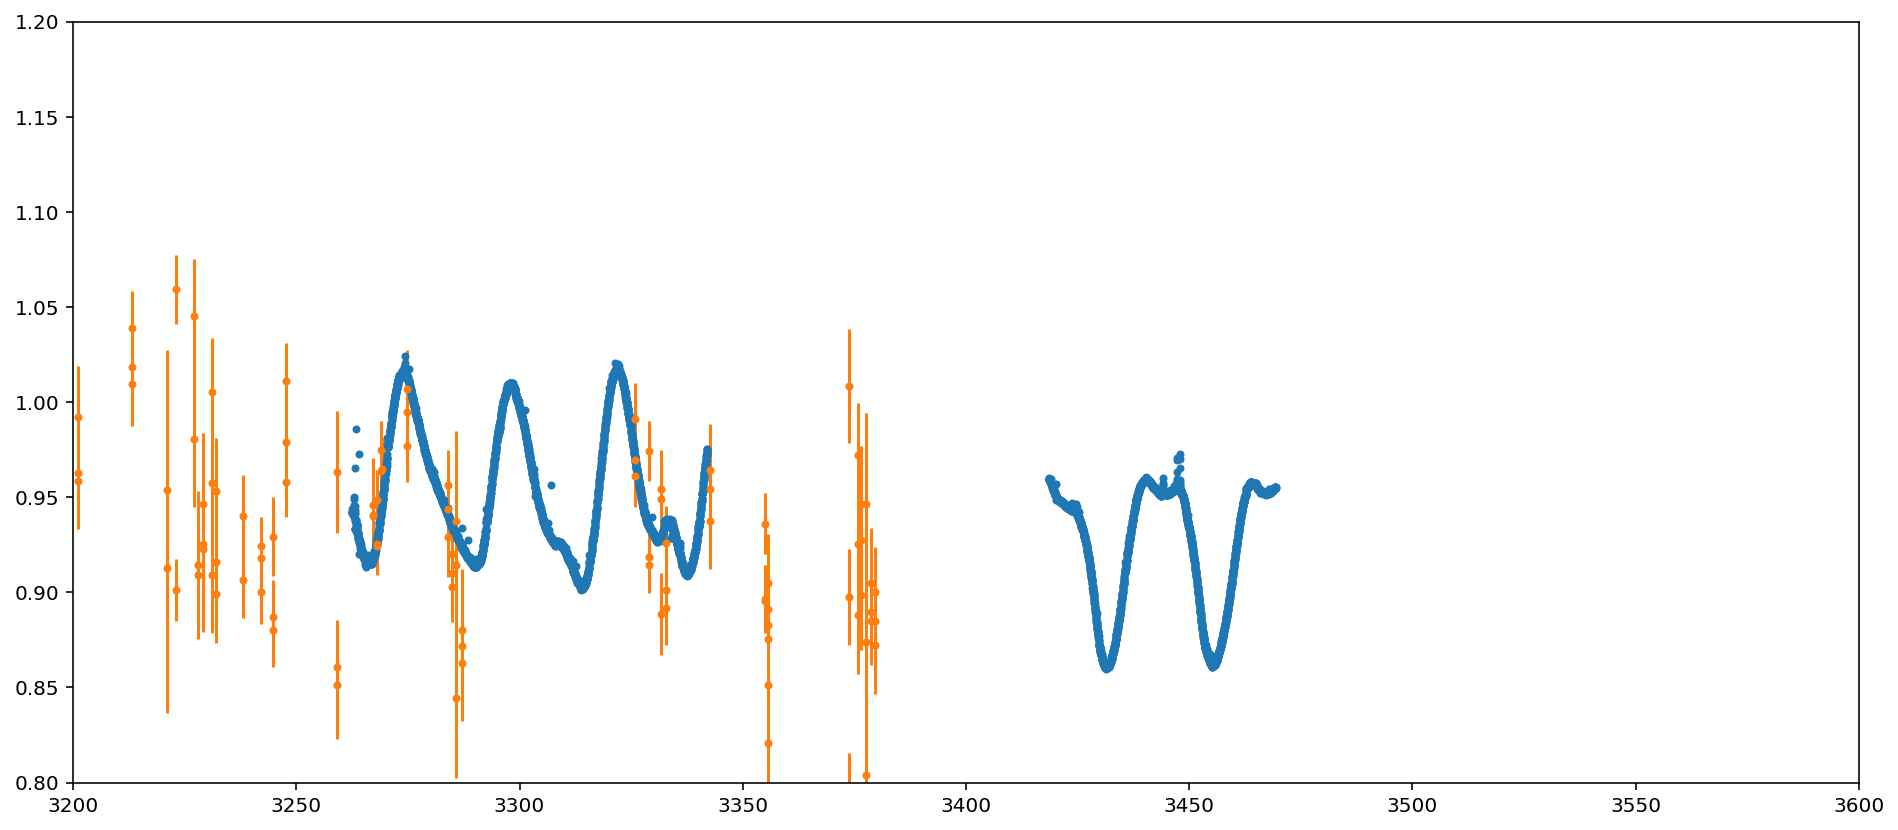

In [7]:
plt.figure(figsize=(16, 7))
plt.plot(df.time, df.flux, '.')
plt.errorbar(df_ASASSN.time, df_ASASSN.flux, df_ASASSN.flux_err,fmt='.')
plt.xlim(3200, 3200+400)
plt.ylim(0.8, 1.2)

Nice

In [8]:
#df = pd.concat([df, df_ASASSN], ignore_index=True)

In [9]:
df_subset = df.sort_values('time').reset_index(drop=True)

In [10]:
t = df_subset.time.values
y = df_subset.flux
yerr = df_subset.flux_err

<ErrorbarContainer object of 3 artists>

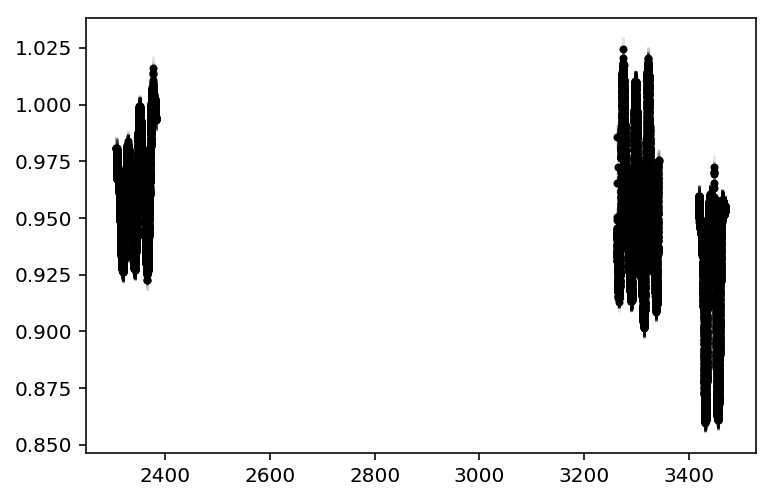

In [11]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)

In [12]:
2.0 * np.pi / 23.5, 2.0 * np.pi / 13

(0.26736958753955686, 0.483321946706122)

In [13]:
import celerite
from celerite import terms

# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [14]:
%%time
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: 41030.05252062243
CPU times: user 4.87 ms, sys: 2.78 ms, total: 7.65 ms
Wall time: 5.3 ms


Text(0, 0.5, 'y')

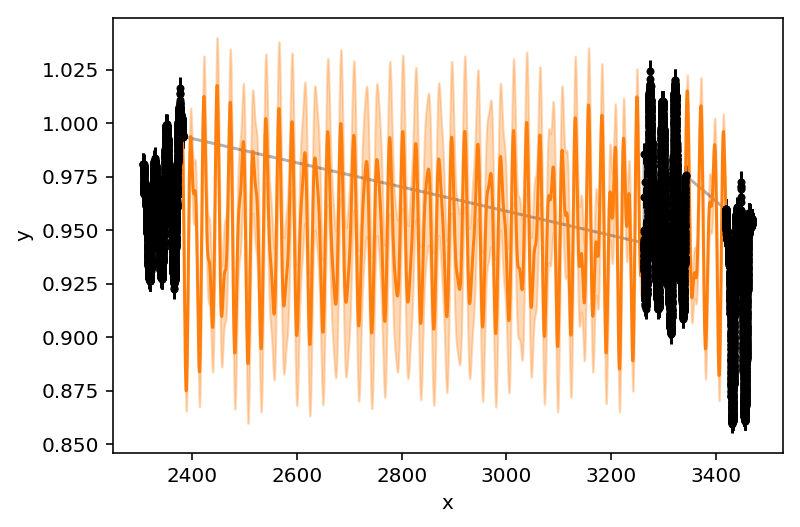

In [15]:
x = np.arange(df_subset.time.iloc[0], df_subset.time.iloc[-1], 1.0/2.0) # HALF DAY SAMPLING ONLY.
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

(3272, 3273)

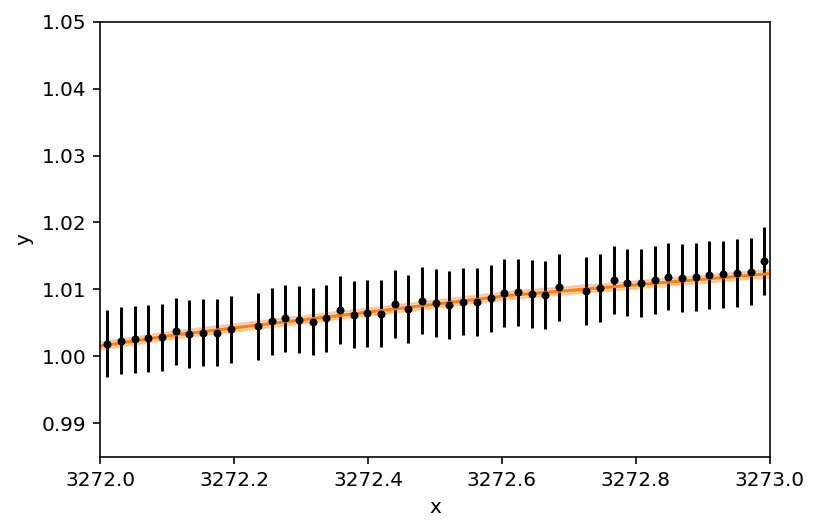

In [16]:
color = "#ff7f0e"
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.ylim(0.985, 1.05)
plt.xlim(3272, 3273)

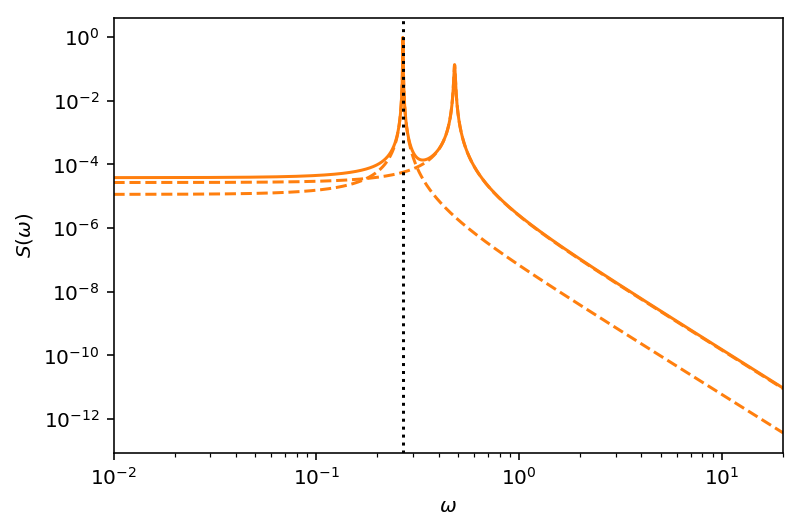

In [17]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

In [18]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -41255.25935139922
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03637979, -0.25174813, -0.0349246 , -0.02037268,  0.77125151])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 552
      nit: 61
   status: 0
  success: True
        x: array([ -7.05265676,  -1.40897417, -12.99503601,   4.44668892,
        -0.62466292])


In [19]:
np.pi*2/10**-0.8290087063581993, np.pi*2/10**-1.3457165415991024

(42.382695572041094, 139.28245400025708)

In [20]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -7.052656763077313),
             ('kernel:terms[0]:log_omega0', -1.4089741747785507),
             ('kernel:terms[1]:log_S0', -12.9950360130757),
             ('kernel:terms[1]:log_Q', 4.4466889160333745),
             ('kernel:terms[1]:log_omega0', -0.6246629191224488)])

In [21]:
x = np.arange(df.time.iloc[0], df.time.iloc[-1], 1.0/2.0)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'y')

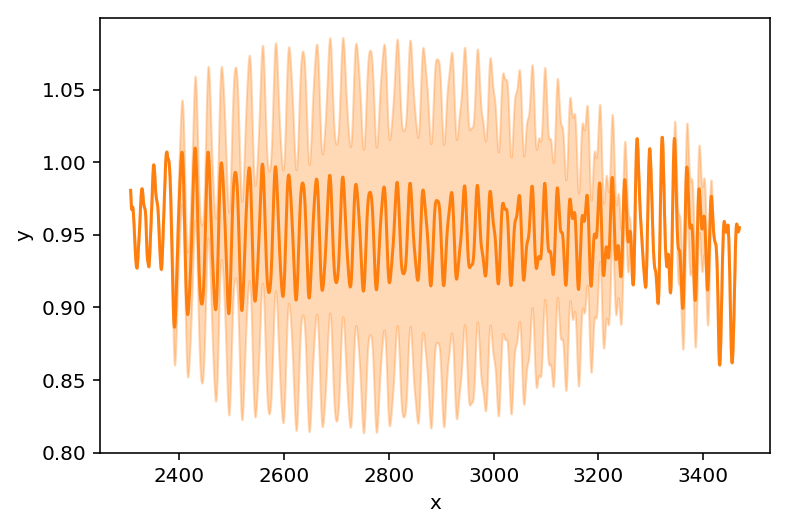

In [22]:
color = "#ff7f0e"
#plt.plot(df.time, df.flux, "k", lw=1.5, alpha=0.3)
#plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

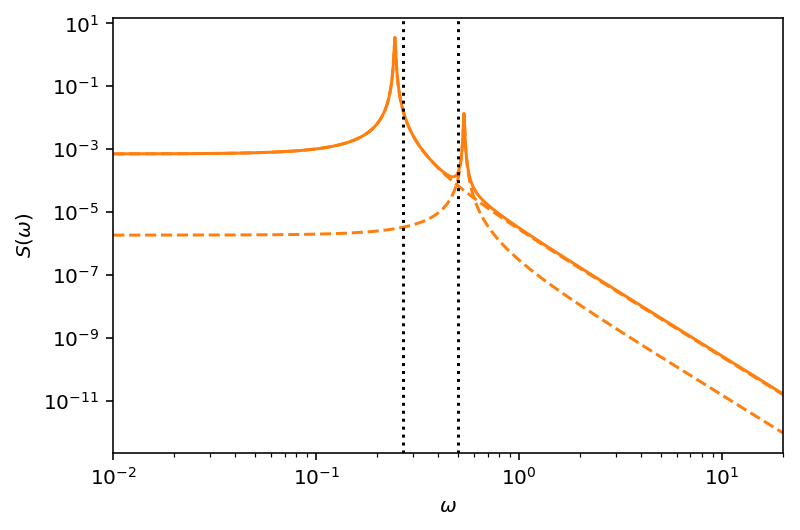

In [23]:
omega = np.exp(np.linspace(np.log(0.01), np.log(20), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)
for k in gp.kernel.terms:
    plt.plot(omega, k.get_psd(omega), "--", color=color)

    
plt.axvline(2.0*np.pi/23.5, color='k', linestyle='dotted')
plt.axvline(2.0*np.pi/12.5, color='k', linestyle='dotted')

plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

## Now let's apply to the ASASSN data!

In [24]:
df_ASASSN = df_ASASSN.sort_values('time').reset_index(drop=True)

In [25]:
t = df_ASASSN.time.values
y = df_ASASSN.flux
yerr = df_ASASSN.flux_err

<ErrorbarContainer object of 3 artists>

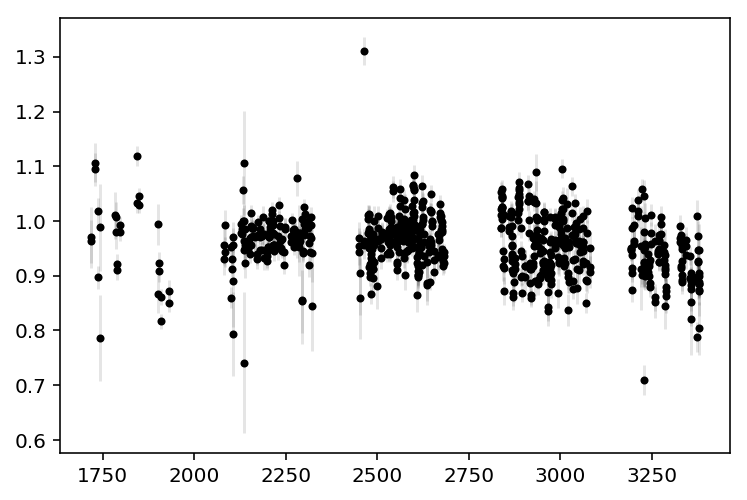

In [26]:
plt.plot(t, y,".k")
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
#plt.ylim(0.985, 1.0)
#plt.xlim(3272, 3273)


In [27]:
gp.get_parameter_vector()

array([ -7.05265676,  -1.40897417, -12.99503601,   4.44668892,
        -0.62466292])

In [28]:
# A non-periodic component
Q = 100 / np.sqrt(2.0)
w0 = 0.48
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

#A periodic component
Q = 300.0
w0 = 0.267
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [29]:
%%time
gp2 = celerite.GP(kernel, mean=np.mean(y))
gp2.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp2.log_likelihood(y)))

Initial log likelihood: 1014.773382604715
CPU times: user 1.87 ms, sys: 1 ms, total: 2.87 ms
Wall time: 1.91 ms


Text(0, 0.5, 'y')

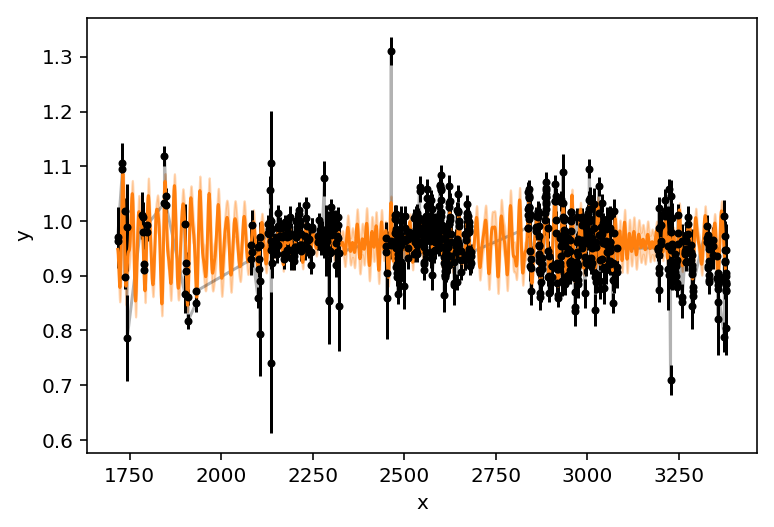

In [30]:
x = np.arange(df_ASASSN.time.iloc[0], df_ASASSN.time.iloc[-1], 1.0/2.0) # HALF DAY SAMPLING!
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")

Let's transfer the GP parameters from K2:

In [31]:
gp2.set_parameter_vector(gp.get_parameter_vector())

CPU times: user 5.66 s, sys: 956 ms, total: 6.62 s
Wall time: 5.39 s


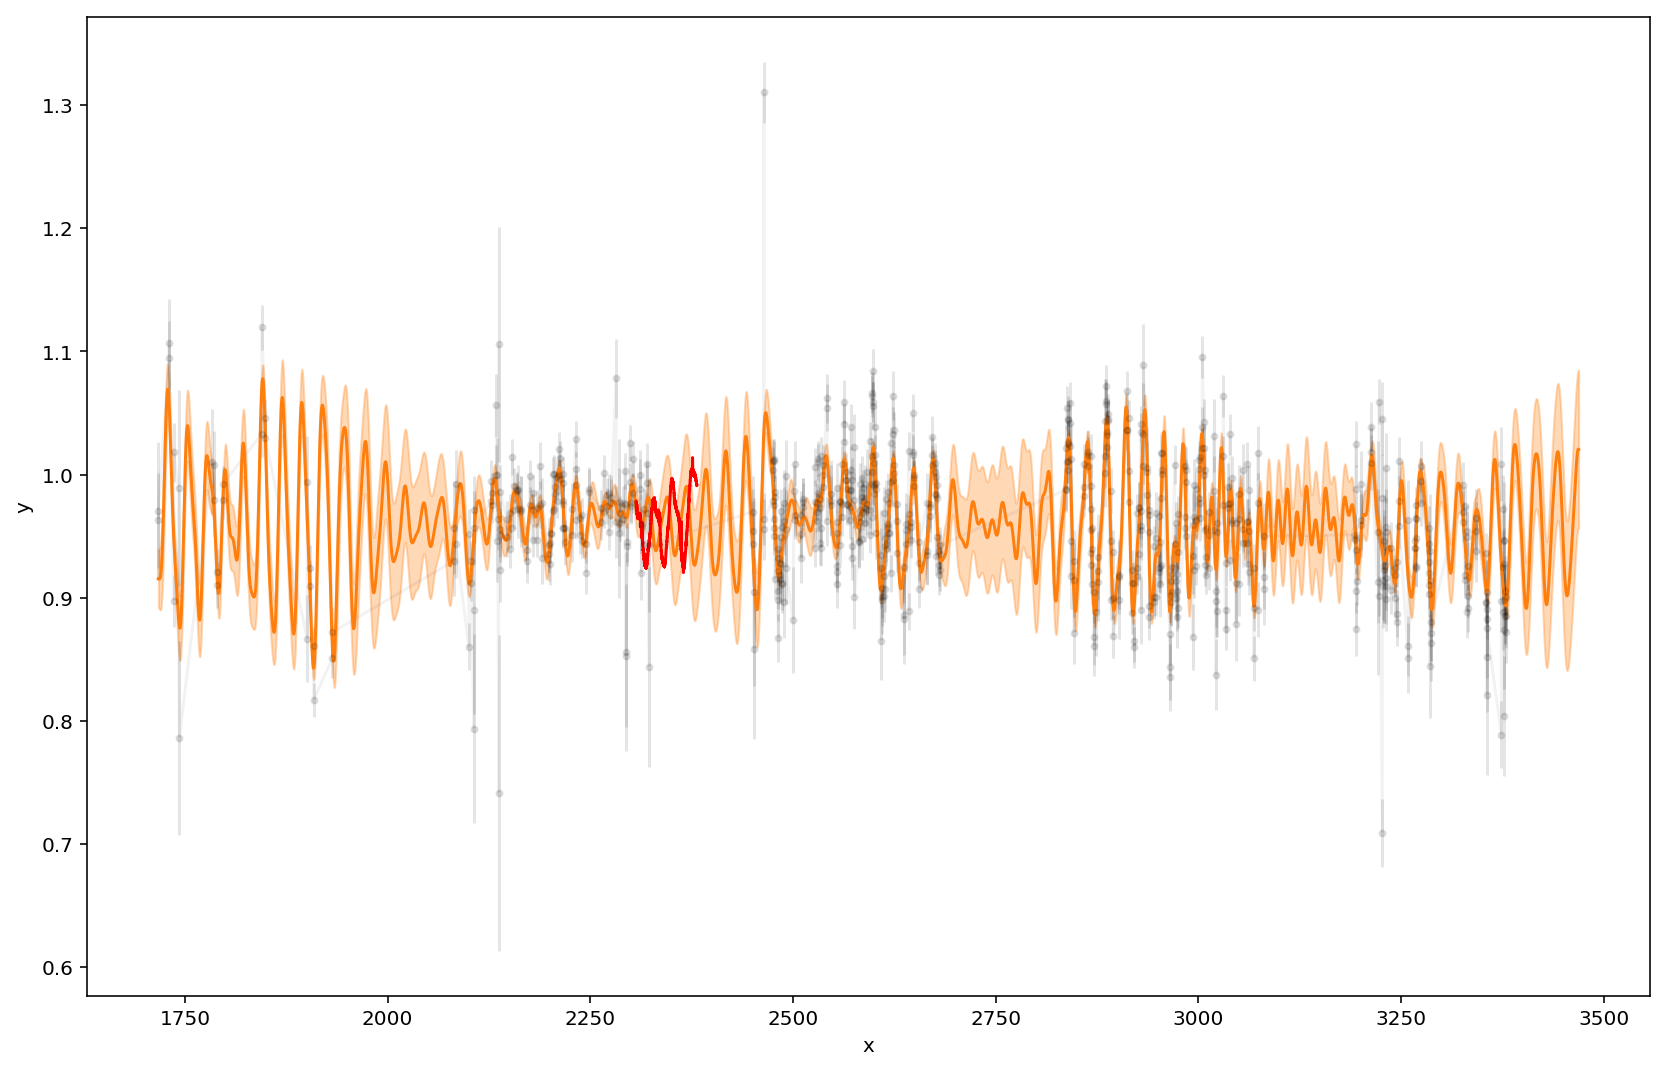

In [32]:
%%time
plt.figure(figsize=(14, 9))
x = np.arange(df_ASASSN.time.iloc[0], df.time.iloc[-1], 1.0/2.0) #half-day sampling
pred_mean, pred_var = gp2.predict(y, x, return_var=True)
pred_mean_K2, pred_var_K2 = gp.predict(df.flux.values, x, return_var=True)
pred_std = np.sqrt(pred_var)
pred_std_K2 = np.sqrt(pred_var_K2)

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
#plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

#plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
#                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")

In [33]:
%matplotlib inline

(1700, 2200)

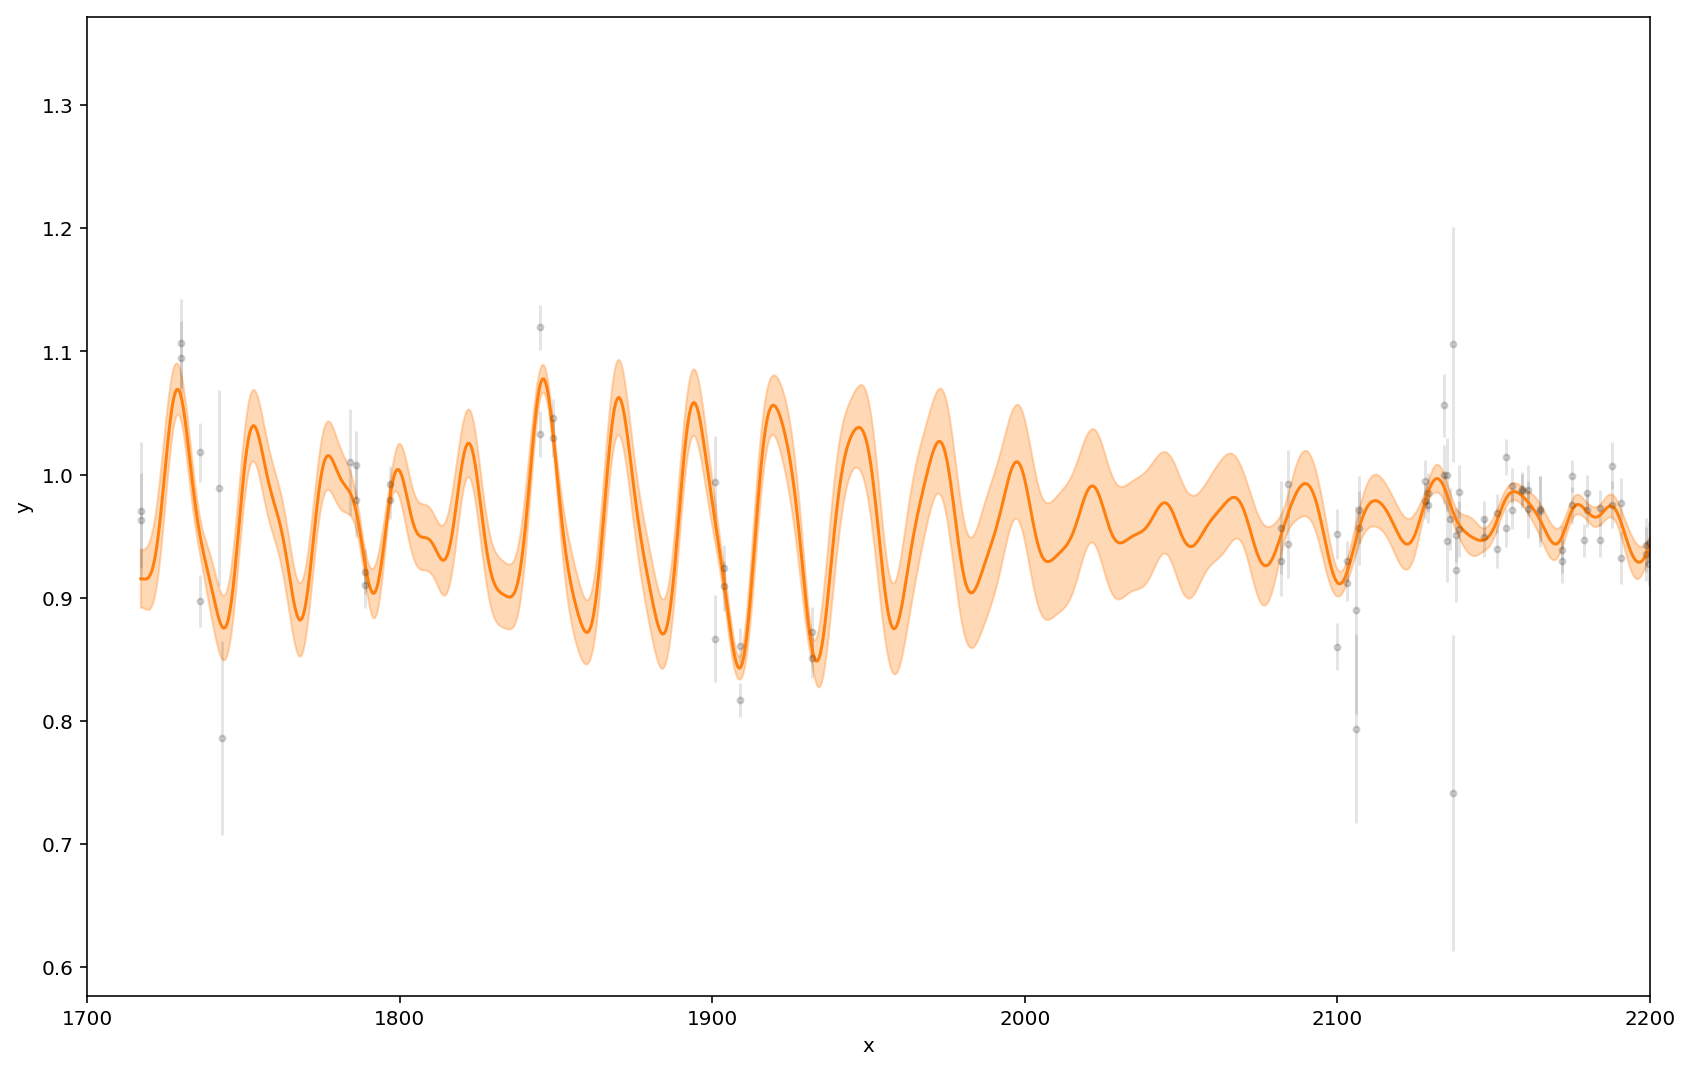

In [34]:
plt.figure(figsize=(14, 9))

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k.", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")

plt.xlim(1700, 2200)

CPU times: user 43.8 ms, sys: 2.63 ms, total: 46.5 ms
Wall time: 44.9 ms


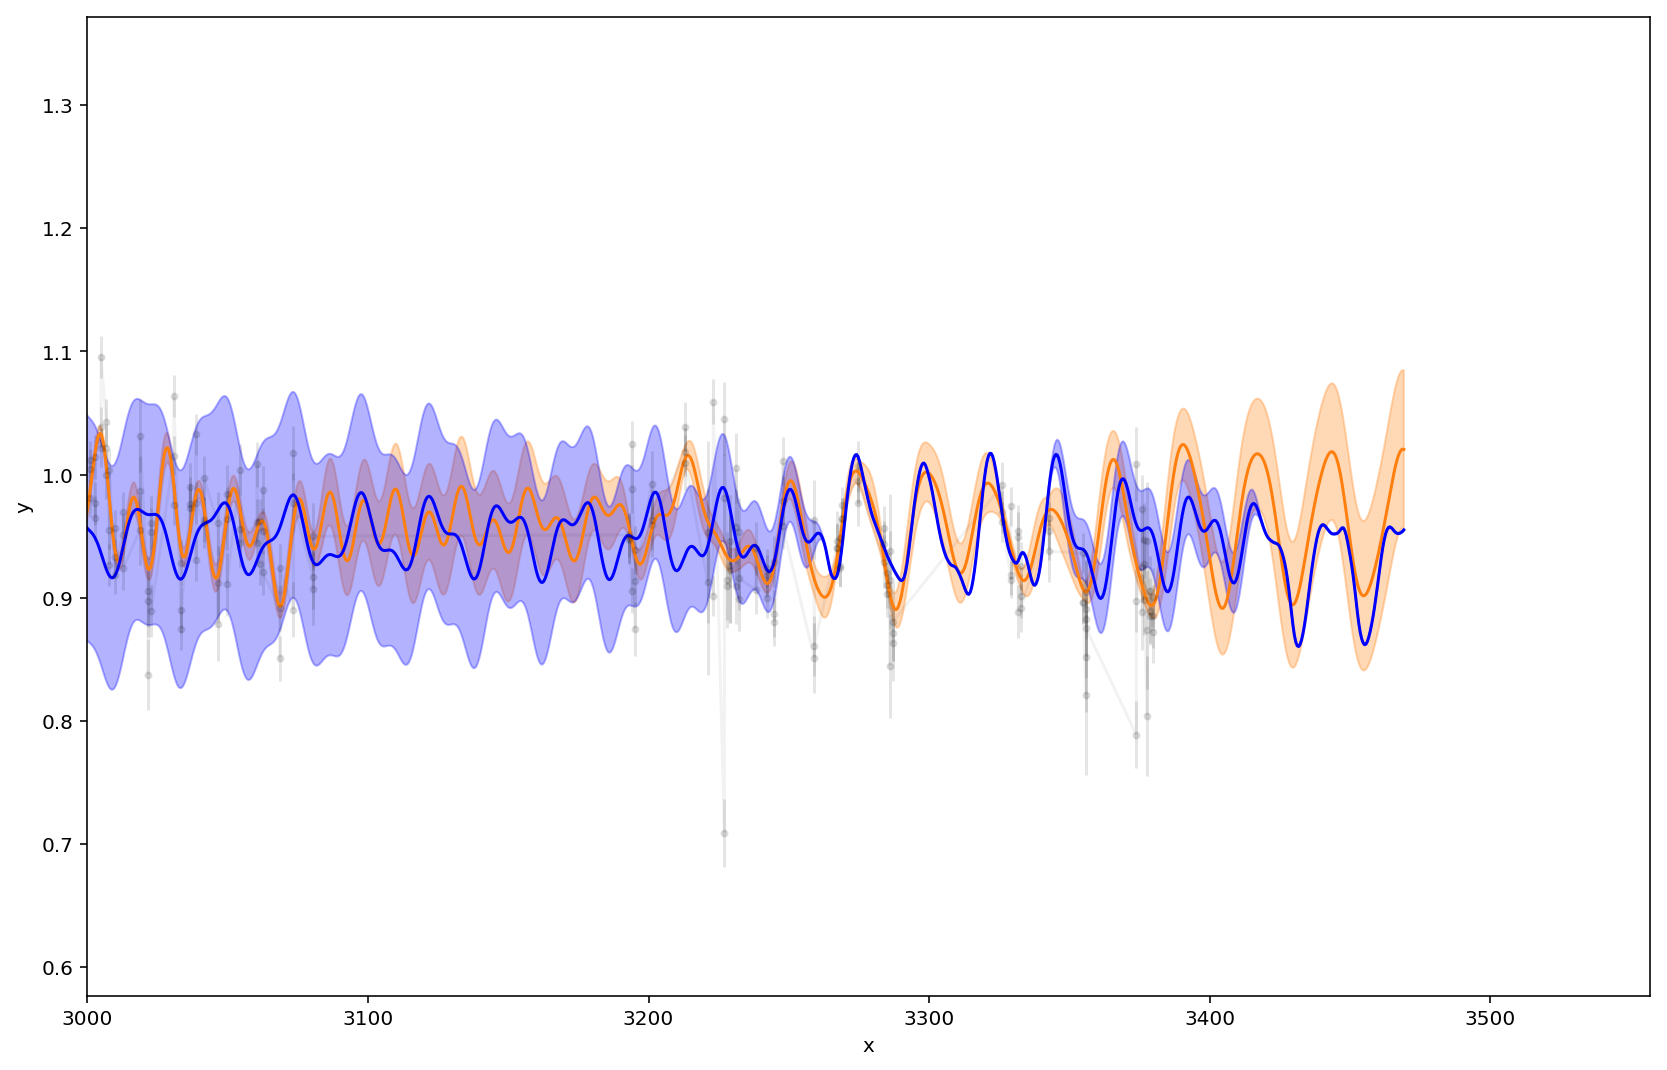

In [35]:
%%time
plt.figure(figsize=(14, 9))

color = "#ff7f0e"
plt.plot(df_ASASSN.time, df_ASASSN.flux, "k", lw=1.5, alpha=0.05)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, alpha=0.1)
plt.plot(x, pred_mean, color=color)
plt.plot(x, pred_mean_K2, color='b')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")

plt.fill_between(x, pred_mean_K2+pred_std_K2, pred_mean_K2-pred_std_K2, color='b', alpha=0.3,
                 edgecolor="none")

plt.plot(dfC05.time, dfC05.flux/np.nanpercentile(dfC05.flux, 95), "r", lw=1.5, alpha=1)

plt.xlabel("x")
plt.ylabel("y")
plt.xlim(3000)

In [36]:
def compute_K2_zeropoints(df_K2_campaign):
    '''compute the K2 flux absolute value per campaign'''
    df_K2_campaign.time
    x = df_K2_campaign.time.values
    pred_mean, pred_var = gp2.predict(y, x, return_var=True)
    ratio = np.median(df_K2_campaign.flux/pred_mean)
    return ratio

In [37]:
compute_K2_zeropoints(dfC05), compute_K2_zeropoints(dfC16), compute_K2_zeropoints(dfC18)

(1.0023508198523543, 0.9979590222886735, 0.9609640559019518)

## Publication quality version

In [45]:
from astropy.time import Time
times = ['2014-01-01T00:00:00.0', '2015-01-01T00:00:00.0', 
         '2016-01-01T00:00:00.0', '2017-01-01T00:00:00.0', '2018-01-01T00:00:00.0']
#times = ['2018-01-01T00:00:00.0']
nye_t = Time(times, format='isot', scale='utc')

nye_tick_locations = nye_t.jd - 2454833
#nye_t.decimalyear

CPU times: user 999 ms, sys: 13.8 ms, total: 1.01 s
Wall time: 1.01 s


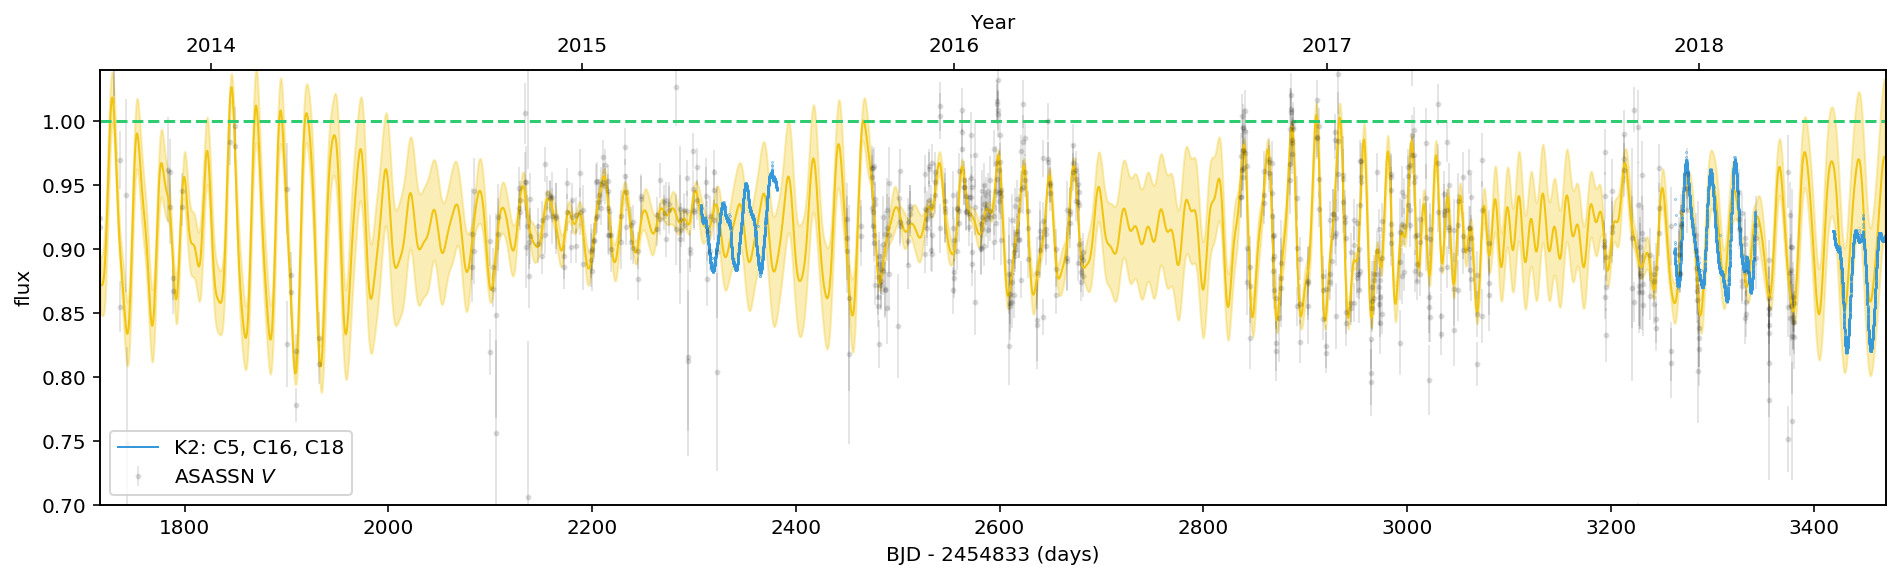

In [46]:
%%time
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

peak = 1.05

color = "#f1c40f"
ax1.errorbar(t, y/peak, yerr=yerr/peak, fmt=".k", ms=4, capsize=0, alpha=0.1, lw=1, label='ASASSN $V$')
ax1.plot(x, pred_mean/peak, color=color, lw=1)
ax1.fill_between(x, pred_mean/peak+pred_std/peak, pred_mean/peak-pred_std/peak, color=color, alpha=0.3,
                 edgecolor="none", lw=1)

ax1.plot(df.time, df.flux.values/peak, '.', color="#3498db", alpha=1, ms=0.5)
ax1.plot(df.time, 0.0*df.flux-10, '-', color="#3498db", alpha=1, lw=1, label='K2: C5, C16, C18')

ax1.axhline(1.0, linestyle='dashed', color='#2ecc71')

ax1.set_xlabel("BJD - 2454833 (days)")
ax1.set_ylabel("flux")
ax1.set_ylim(0.7, 1.04)
ax1.set_xlim(1717, 3470)
#ax1.set_xlim(3200, 3470)

ax1.legend(loc='lower left')

ax2.set_xlim(1717, 3470)
#ax2.set_xlim(3200, 3470)
ax2.set_xticks(nye_tick_locations)
ax2.set_xticklabels(nye_t.decimalyear.astype(np.int))
ax2.set_xlabel("Year")


plt.savefig('../document/figures/five_year_lightcurve_V.pdf', bbox_inches='tight')

In [41]:
df_ASASSN.time.iloc[0], df.time.iloc[-1]

(1717.1368599999696, 3469.3811144519127)

The end!